In [1]:
import sys
import glob
import os
import math
import pandas as pd
import numpy as np
import geopandas as gp

import matplotlib.pyplot as plt
import rsfuncs as rs

from scipy import stats
from scipy.signal import savgol_filter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold

from pandas.tseries.offsets import MonthEnd, SemiMonthEnd
from datetime import datetime, timedelta
from datetime import datetime as dt

from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import regularizers, optimizers

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
# Read data
states_file = gp.read_file("../shape/states.shp")
states = states_file[~states_file['STATE_ABBR'].isin(["AK", "HI", "PR", "VI"])]

site_file = gp.read_file("../shape/scan_sites.shp")
sites = site_file[~site_file['state'].isin(["AK", "HI", "PR", "VI"])]

# formate data 
df = pd.read_csv("../data/all_dat_f.csv")
df.rename(columns={ df.columns[0]: "site" , df.columns[1]:"date"}, inplace = True)
df.replace([np.inf, -np.inf], np.nan, inplace = True)
df = df.set_index(pd.to_datetime(df.date))
df['date'] = pd.to_datetime(df.date)

In [3]:
# Filter the data

# Drop days with 2day precip less than 1 mm
df = df[df.precip<1]

# Remove Urban Areas
df = df[df.lc_type != 2]
df = df[df.lc_type != 3]

# Remove sites with <10 datapoints
for i in df.site.unique():
    if len(df[df.site == i]) < 10:
        df = df[df.site != i]

# Calculate spectral indices
df['ndvi'] = (df.B5 - df.B4) / (df.B5 + df.B4)
df["ndmi"] = (df.B5 - df.B6) / (df.B5 + df.B6)
df["evi"] = 2.5*(df.B5 - df.B4) / (df.B5 + 6*df.B4- 7.5*df.B2 + 1)

# For the backscatter columns (df.vv, df.hv), delete any zeros, nans, deal with weird formatting, and calc the mean 
vv_eff = []

for i in df.vv:
    line = i.replace("[","")
    line = line.replace("]","")
    line = ' '.join(line.split())
    data = [float(i) for i in line.split(' ')]
    data = [i for i in data if i !=0.]
    vv_eff.append(np.nanmean(data))
    

hv_eff = []

for i in df.hv:
    if type(i) is float:
        hv_eff.append(np.nan)
    else:
        line = i.replace("[","")
        line = line.replace("]","")
        line = ' '.join(line.split())
        data = [float(i) for i in line.split(' ')]
        data = [i for i in data if i !=0.]
        hv_eff.append(np.nanmean(data))


df['vv'] = vv_eff
df['hv'] = hv_eff

# calc the 12 day means for each site: 
df = df.groupby(['site']).resample('12D').mean().fillna(np.nan).dropna()


# def compute_lags(df, n=3):
#     df['vv_t1'] = df['vv'].shift(1)
#     df['hv_t1'] = df['hv'].shift(1)
#     df['vv_t2'] = df['vv'].shift(2)
#     df['hv_t2'] = df['hv'].shift(2)
#     df['vv_t3'] = df['vv'].shift(3)
#     df['hv_t3'] = df['hv'].shift(3)

#     return df

# df = compute_lags(df)

In [4]:
# Drop the non interpolated landsat bands
cols = [c for c in df.columns if 'filt' not in c]
df=df[cols]

In [5]:
# Add the time lagged predictors 
s1 = df.groupby(level="site").shift(1)
df1 = df.join(s1.rename(columns=lambda x: x+"_t1"))

s2 = df.groupby(level="site").shift(2)
df2 = df1.join(s2.rename(columns=lambda x: x+"_t2"))

s3 = df.groupby(level="site").shift(3)
df3 = df2.join(s3.rename(columns=lambda x: x+"_t3"))

In [6]:
# Drop unnecessary cols 

In [7]:
dropstrs = ['site','precip',"lc_type_", 'rzsm', 'ssm', 'psi_rz_', "psi_s"]
dropcols = []

for i in df3.columns:
    for x in dropstrs:
        if x in i:
            dropcols.append(i)
            
df3 = df3.drop(dropcols, axis = 1)

In [8]:
# One hot encode the landcover types *** figure this out
# one_hot = pd.get_dummies(df3.lc_type, drop_first=True )
# rdf = pd.concat([df3, one_hot], axis = 1)
# rdf = rdf.drop(["lc_type"], axis = 1)
# df = rdf.reset_index(level='site')

In [9]:
df3 = df3.drop(["lc_type"], axis = 1)
df = df3.reset_index(level='site')
df = df.dropna()

In [25]:
# Modeling options

EPOCHS = 100
BATCHSIZE = 50
DROPOUT = 0.25
LOSS = 'mse'

Areg = regularizers.l2(1e-5)
Breg = regularizers.l2(1e-3)
Kreg = regularizers.l2(1e-15)
Rreg = regularizers.l2(1e-15)

def build_model(input_shape):
    # make the model 
    model = Sequential()

    model.add(LSTM(100, input_shape=input_shape, dropout = 0.25,recurrent_dropout=0.05,return_sequences=True,bias_regularizer= Breg))
    model.add(LSTM(50, input_shape=input_shape, dropout = 0.25,recurrent_dropout=0.05,return_sequences=True,bias_regularizer= Breg))
    model.add(LSTM(10, input_shape=input_shape, dropout = 0.25,recurrent_dropout=0.05,bias_regularizer= Breg))

    model.add(Dense(1))
    model.compile(loss="mse", optimizer='adam',metrics=['mse'])
    
    return model


In [26]:
out = {"train_preds":[], # rs
       "test_preds":[], # wells
       "train_act":[], # c2vsim
       "test_act":[]  # grace 
        }

Processing 2157
Train on 2873 samples, validate on 45 samples
Epoch 1/10000
 - 7s - loss: 1.1615 - mean_squared_error: 1.0018 - val_loss: 0.1593 - val_mean_squared_error: 1.5256e-04
Epoch 2/10000
 - 0s - loss: 1.1607 - mean_squared_error: 1.0019 - val_loss: 0.1583 - val_mean_squared_error: 1.3211e-04
Epoch 3/10000
 - 0s - loss: 1.1583 - mean_squared_error: 1.0004 - val_loss: 0.1575 - val_mean_squared_error: 2.2890e-04
Epoch 4/10000
 - 0s - loss: 1.1551 - mean_squared_error: 0.9982 - val_loss: 0.1566 - val_mean_squared_error: 3.0682e-04
Epoch 5/10000
 - 0s - loss: 1.1565 - mean_squared_error: 1.0005 - val_loss: 0.1556 - val_mean_squared_error: 2.8644e-04
Epoch 6/10000
 - 0s - loss: 1.1557 - mean_squared_error: 1.0007 - val_loss: 0.1546 - val_mean_squared_error: 2.0368e-04
Epoch 7/10000
 - 0s - loss: 1.1548 - mean_squared_error: 1.0007 - val_loss: 0.1536 - val_mean_squared_error: 1.6436e-04
Epoch 8/10000
 - 0s - loss: 1.1521 - mean_squared_error: 0.9990 - val_loss: 0.1527 - val_mean_squa

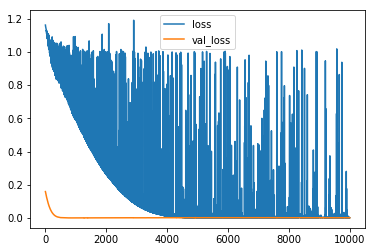

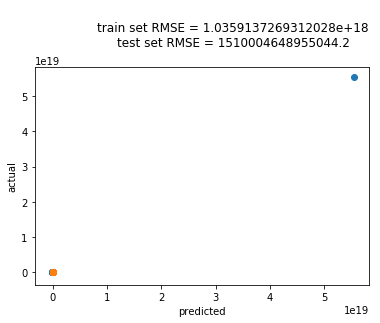

In [36]:
for i in df.site.unique()[40:41]:

    print("Processing {}".format(i))
    
    # Hold one out cross validation - loop through sites and select 1 to test on and the rest to train 
    sdf = df[df.site == i]
    y_test = sdf.psi_rz
    X_test = sdf.drop(["site","psi_rz"], axis=1)

    nsdf = df[df.site != i]
    y_train = nsdf.psi_rz 
    X_train = nsdf.drop(["site","psi_rz"], axis=1)
        
    # Scale data
    transformer_x = StandardScaler().fit(X_train)
    transformer_y = StandardScaler().fit(np.array(y_train).reshape(-1, 1)) 
    
    X_train = transformer_x.transform(X_train)
    y_train = transformer_y.transform(np.array(y_train).reshape(-1, 1))
    X_test = transformer_x.transform(X_test)
    y_test = transformer_y.transform(np.array(y_test).reshape(-1, 1))
    
    # LSTM params
    n_lags = 4
    n_features = 12

    X_train = X_train.reshape((X_train.shape[0], n_lags, 12))
    X_test = X_test.reshape((X_test.shape[0], n_lags, 12))

    input_shape=(X_train.shape[1], X_train.shape[2])
    
    model = build_model(input_shape=input_shape)
    
    # Fit
#     model.fit(X_train, y_train, epochs=1000, batch_size=1000, verbose=1)
    
    train_history = model.fit(X_train, y_train,epochs = 10000,
                    batch_size=1000,
                    verbose=2, validation_data=(X_test, y_test))
    loss = train_history.history['loss']
    val_loss = train_history.history['val_loss']
    val_acc = train_history.history['val_mean_squared_error']

    # Get the predictions
    yhat_train = model.predict(X_train)
    
    trainPredict = transformer_y.inverse_transform(yhat_train.reshape(-1,1))
    trainY = transformer_y.inverse_transform(y_train)
    
    yhat = model.predict(X_test)
    testPredict = transformer_y.inverse_transform(yhat.reshape(-1,1))
    testY = transformer_y.inverse_transform(y_test)

    trainScore = math.sqrt(mean_squared_error(y_train, trainPredict))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(y_test, testPredict))
    print('Test Score: %.2f RMSE' % (testScore))
    
    out["test_preds"] = testPredict
    out["train_preds"] = trainPredict
    
    out["test_act"] = testY
    out["train_act"] = trainY
    
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['loss', 'val_loss'])
    plt.show()


    plt.scatter(trainPredict, trainY)
    plt.scatter(testPredict, testY)
    plt.title('''
                train set RMSE = {}
                test set RMSE = {}
                '''.format(round(trainScore,2),round(testScore,2)))

    plt.xlabel("predicted")
    plt.ylabel("actual")
    plt.show()

Text(0, 0.5, 'actual')

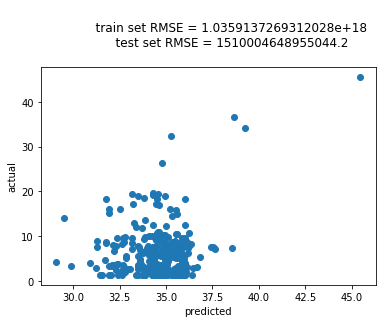

In [38]:
plt.scatter(np.log(trainPredict), np.log(trainY))
plt.scatter(np.log(testPredict), np.log(testY))
plt.title('''
            train set RMSE = {}
            test set RMSE = {}
            '''.format(round(trainScore,2),round(testScore,2)))

plt.xlabel("predicted")
plt.ylabel("actual")

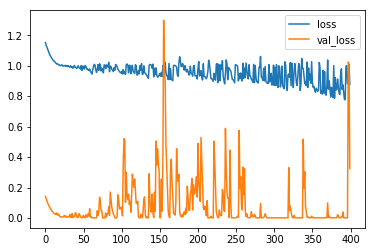

In [35]:

plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss', 'val_loss'])
plt.show()

In [15]:
predicted

NameError: name 'predicted' is not defined